# Data Mining the Water Table

***

## Project Description

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

## Data Dictionary

| Field                                                    | Description                                 |
|----------------|---------------------------------------------------------------------------------------|

    amount_tsh - Total static head (amount water available to waterpoint)
    date_recorded - The date the row was entered
    funder - Who funded the well
    gps_height - Altitude of the well
    installer - Organization that installed the well
    longitude - GPS coordinate
    latitude - GPS coordinate
    wpt_name - Name of the waterpoint if there is one
    num_private -
    basin - Geographic water basin
    subvillage - Geographic location
    region - Geographic location
    region_code - Geographic location (coded)
    district_code - Geographic location (coded)
    lga - Geographic location
    ward - Geographic location
    population - Population around the well
    public_meeting - True/False
    recorded_by - Group entering this row of data
    scheme_management - Who operates the waterpoint
    scheme_name - Who operates the waterpoint
    permit - If the waterpoint is permitted
    construction_year - Year the waterpoint was constructed
    extraction_type - The kind of extraction the waterpoint uses
    extraction_type_group - The kind of extraction the waterpoint uses
    extraction_type_class - The kind of extraction the waterpoint uses
    management - How the waterpoint is managed
    management_group - How the waterpoint is managed
    payment - What the water costs
    payment_type - What the water costs
    water_quality - The quality of the water
    quality_group - The quality of the water
    quantity - The quantity of water
    quantity_group - The quantity of water
    source - The source of the water
    source_type - The source of the water
    source_class - The source of the water
    waterpoint_type - The kind of waterpoint
    waterpoint_type_group - The kind of waterpoint


## Import Libraries

In [1]:
import numpy as np
from numpy import count_nonzero, median, mean
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random

import sklearn

# import shap
# import eli5
# from IPython.display import display
import statsmodels.api as sm

import datetime
from datetime import datetime, timedelta


import scipy.stats

#import pandas_profiling
#from pandas_profiling import ProfileReport

#import graphviz

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
#from sklearn.pipeline import Pipeline
#from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif, f_regression, chi2
#from sklearn.inspection import permutation_importance

from sklearn.tree import export_graphviz, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, LogisticRegression, Ridge
#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier, ExtraTreeRegressor, plot_tree
#from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
#from sklearn.naive_bayes import GaussianNB, MultinomialNB
#from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor
#from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor



%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)


#from tpot import TPOTClassifier, TPOTRegressor
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# import pickle
# from pickle import dump, load

# Use Folium library to plot values on a map.
#import folium

# Use Feature-Engine library

#import feature_engine.missing_data_imputers as mdi
#from feature_engine.outlier_removers import Winsorizer
#from feature_engine import categorical_encoders as ce


#from pycaret.classification import *
#from pycaret.clustering import *
#from pycaret.regression import *

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format','{:.2f}'.format)


random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


## Exploratory Data Analysis

In [2]:
df = pd.read_csv("train.csv",parse_dates=['date_recorded'])

In [3]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.00,2011-03-14,Roman,1390,Roman,34.94,-9.86,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.00,2013-06-03,Grumeti,1399,GRUMETI,34.70,-2.15,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.00,2013-02-25,Lottery Club,686,World vision,37.46,-3.82,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.00,2013-01-28,Unicef,263,UNICEF,38.49,-11.16,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.00,2011-07-13,Action In A,0,Artisan,31.13,-1.83,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  int64         
 1   amount_tsh             59400 non-null  float64       
 2   date_recorded          59400 non-null  datetime64[ns]
 3   funder                 55765 non-null  object        
 4   gps_height             59400 non-null  int64         
 5   installer              55745 non-null  object        
 6   longitude              59400 non-null  float64       
 7   latitude               59400 non-null  float64       
 8   wpt_name               59400 non-null  object        
 9   num_private            59400 non-null  int64         
 10  basin                  59400 non-null  object        
 11  subvillage             59029 non-null  object        
 12  region                 59400 non-null  object        
 13  r

In [5]:
df.describe(include='all')

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400.00,59400.00,59400,55765,59400.00,55745,59400.00,59400.00,59400,59400.00,59400,59029,59400,59400.00,59400.00,59400,59400,59400.00,56066,59400,55523,31234,56344,59400.00,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,NaN,NaN,356,1897,NaN,2145,NaN,NaN,37400,NaN,9,19287,21,NaN,NaN,125,2092,NaN,2,1,12,2696,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,NaN,NaN,2011-03-15 00:00:00,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Lake Victoria,Madukani,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd,VWC,K,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,NaN,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,10248,508,5294,NaN,NaN,2503,307,NaN,51011,59400,36793,682,38852,NaN,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259
first,NaN,NaN,2002-10-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2013-12-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,37115.13,317.65,NaN,NaN,668.30,NaN,34.08,-5.71,NaN,0.47,NaN,NaN,NaN,15.30,5.63,NaN,NaN,179.91,NaN,NaN,NaN,NaN,NaN,1300.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,21453.13,2997.57,NaN,NaN,693.12,NaN,6.57,2.95,NaN,12.24,NaN,NaN,NaN,17.59,9.63,NaN,NaN,471.48,NaN,NaN,NaN,NaN,NaN,951.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.00,0.00,NaN,NaN,-90.00,NaN,0.00,-11.65,NaN,0.00,NaN,NaN,NaN,1.00,0.00,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,18519.75,0.00,NaN,NaN,0.00,NaN,33.09,-8.54,NaN,0.00,NaN,NaN,NaN,5.00,2.00,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.shape

(59400, 41)

In [7]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group'], dtype='object')

### Drop unwanted features

In [8]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group'], dtype='object')

In [9]:
df.drop(['id', 'date_recorded','funder', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
        'basin', 'subvillage', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 
         'scheme_name', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group',
        'payment_type', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group'], axis=1, inplace=True)

In [10]:
df.head()

,amount_tsh,gps_height,region,population,public_meeting,permit,construction_year,extraction_type,payment,water_quality,quantity,source,waterpoint_type,status_group
0,6000.00,1390,Iringa,109,True,False,1999,gravity,pay annually,soft,enough,spring,communal standpipe,functional
1,0.00,1399,Mara,280,NaN,True,2010,gravity,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional
2,25.00,686,Manyara,250,True,True,2009,gravity,pay per bucket,soft,enough,dam,communal standpipe multiple,functional
3,0.00,263,Mtwara,58,True,True,1986,submersible,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional
4,0.00,0,Kagera,0,True,True,0,gravity,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional


### Replacing values

In [11]:
df["construction_year"].replace(to_replace=0, value=np.nan, inplace=True)

In [12]:
df["construction_year"].value_counts()

2010.00    2645
2008.00    2613
2009.00    2533
2000.00    2091
2007.00    1587
2006.00    1471
2003.00    1286
2011.00    1256
2004.00    1123
2012.00    1084
2002.00    1075
1978.00    1037
1995.00    1014
2005.00    1011
1999.00     979
1998.00     966
1990.00     954
1985.00     945
1996.00     811
1980.00     811
1984.00     779
1982.00     744
1994.00     738
1972.00     708
1974.00     676
1997.00     644
1992.00     640
1993.00     608
2001.00     540
1988.00     521
1983.00     488
1975.00     437
1986.00     434
1976.00     414
1970.00     411
1991.00     324
1989.00     316
1987.00     302
1981.00     238
1977.00     202
1979.00     192
1973.00     184
2013.00     176
1971.00     145
1960.00     102
1967.00      88
1963.00      85
1968.00      77
1969.00      59
1964.00      40
1962.00      30
1961.00      21
1965.00      19
1966.00      17
Name: construction_year, dtype: int64

### Treat Missing Values

In [13]:
df.isnull().sum()

amount_tsh               0
gps_height               0
region                   0
population               0
public_meeting        3334
permit                3056
construction_year    20709
extraction_type          0
payment                  0
water_quality            0
quantity                 0
source                   0
waterpoint_type          0
status_group             0
dtype: int64

In [14]:
df.dropna(inplace=True)

In [15]:
df.isnull().sum()

amount_tsh           0
gps_height           0
region               0
population           0
public_meeting       0
permit               0
construction_year    0
extraction_type      0
payment              0
water_quality        0
quantity             0
source               0
waterpoint_type      0
status_group         0
dtype: int64

In [16]:
df.reset_index(drop=True, inplace=True)

In [17]:
df

,amount_tsh,gps_height,region,population,public_meeting,permit,construction_year,extraction_type,payment,water_quality,quantity,source,waterpoint_type,status_group
0,6000.00,1390,Iringa,109,True,False,1999.00,gravity,pay annually,soft,enough,spring,communal standpipe,functional
1,25.00,686,Manyara,250,True,True,2009.00,gravity,pay per bucket,soft,enough,dam,communal standpipe multiple,functional
2,0.00,263,Mtwara,58,True,True,1986.00,submersible,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional
3,20.00,0,Tanga,1,True,True,2009.00,submersible,pay per bucket,salty,enough,other,communal standpipe multiple,functional
4,0.00,62,Pwani,345,True,False,2011.00,submersible,never pay,salty,enough,machine dbh,other,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34696,0.00,540,Kilimanjaro,210,True,True,1967.00,gravity,never pay,soft,enough,river,communal standpipe,non functional
34697,500.00,351,Morogoro,89,True,True,2007.00,submersible,pay monthly,soft,enough,machine dbh,communal standpipe,non functional
34698,10.00,1210,Kilimanjaro,125,True,True,1999.00,gravity,pay per bucket,soft,enough,spring,communal standpipe,functional
34699,4700.00,1212,Iringa,56,True,True,1996.00,gravity,pay annually,soft,enough,river,communal standpipe,functional


In [18]:
df["age"] = 2022 - df["construction_year"]

In [19]:
df.head()

,amount_tsh,gps_height,region,population,public_meeting,permit,construction_year,extraction_type,payment,water_quality,quantity,source,waterpoint_type,status_group,age
0,6000.00,1390,Iringa,109,True,False,1999.00,gravity,pay annually,soft,enough,spring,communal standpipe,functional,23.00
1,25.00,686,Manyara,250,True,True,2009.00,gravity,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,13.00
2,0.00,263,Mtwara,58,True,True,1986.00,submersible,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,36.00
3,20.00,0,Tanga,1,True,True,2009.00,submersible,pay per bucket,salty,enough,other,communal standpipe multiple,functional,13.00
4,0.00,62,Pwani,345,True,False,2011.00,submersible,never pay,salty,enough,machine dbh,other,functional,11.00


In [20]:
df.describe(include='all')

,amount_tsh,gps_height,region,population,public_meeting,permit,construction_year,extraction_type,payment,water_quality,quantity,source,waterpoint_type,status_group,age
count,34701.00,34701.00,34701,34701.00,34701,34701,34701.00,34701,34701,34701,34701,34701,34701,34701,34701.00
unique,NaN,NaN,17,NaN,2,2,NaN,18,7,8,5,10,7,3,NaN
top,NaN,NaN,Iringa,NaN,True,True,NaN,gravity,never pay,soft,enough,spring,communal standpipe,functional,NaN
freq,NaN,NaN,4917,NaN,31974,25012,NaN,18684,12591,30651,20744,11739,19243,19782,NaN
mean,492.25,987.60,NaN,268.18,NaN,NaN,1996.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.23
std,3136.09,624.69,NaN,549.24,NaN,NaN,12.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.49
min,0.00,-63.00,NaN,0.00,NaN,NaN,1960.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.00
25%,0.00,353.00,NaN,30.00,NaN,NaN,1986.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.00
50%,0.00,1109.00,NaN,150.00,NaN,NaN,2000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.00
75%,200.00,1477.00,NaN,300.00,NaN,NaN,2008.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.00


### Groupby Function

In [21]:
df.groupby("status_group")['amount_tsh','gps_height','population','age'].mean()

,amount_tsh,gps_height,population,age
status_group,,,,
functional,673.21,1070.91,265.64,22.28
functional needs repair,492.86,1032.21,293.05,26.94
non functional,208.88,849.15,267.68,29.53


In [22]:
df.groupby("status_group")["region","public_meeting","permit"].count()

,region,public_meeting,permit
status_group,,,
functional,19782,19782,19782
functional needs repair,2281,2281,2281
non functional,12638,12638,12638


In [23]:
df.groupby("region")["status_group"].count()

region
Arusha           2842
Dar es Salaam     341
Iringa           4917
Kigoma           2778
Kilimanjaro      4191
Lindi            1257
Manyara          1525
Mara              932
Morogoro         3956
Mtwara           1613
Mwanza            324
Pwani            2453
Rukwa            1754
Ruvuma           2104
Shinyanga         162
Singida          1101
Tanga            2451
Name: status_group, dtype: int64

## Data Visualization

### Univariate Data Exploration

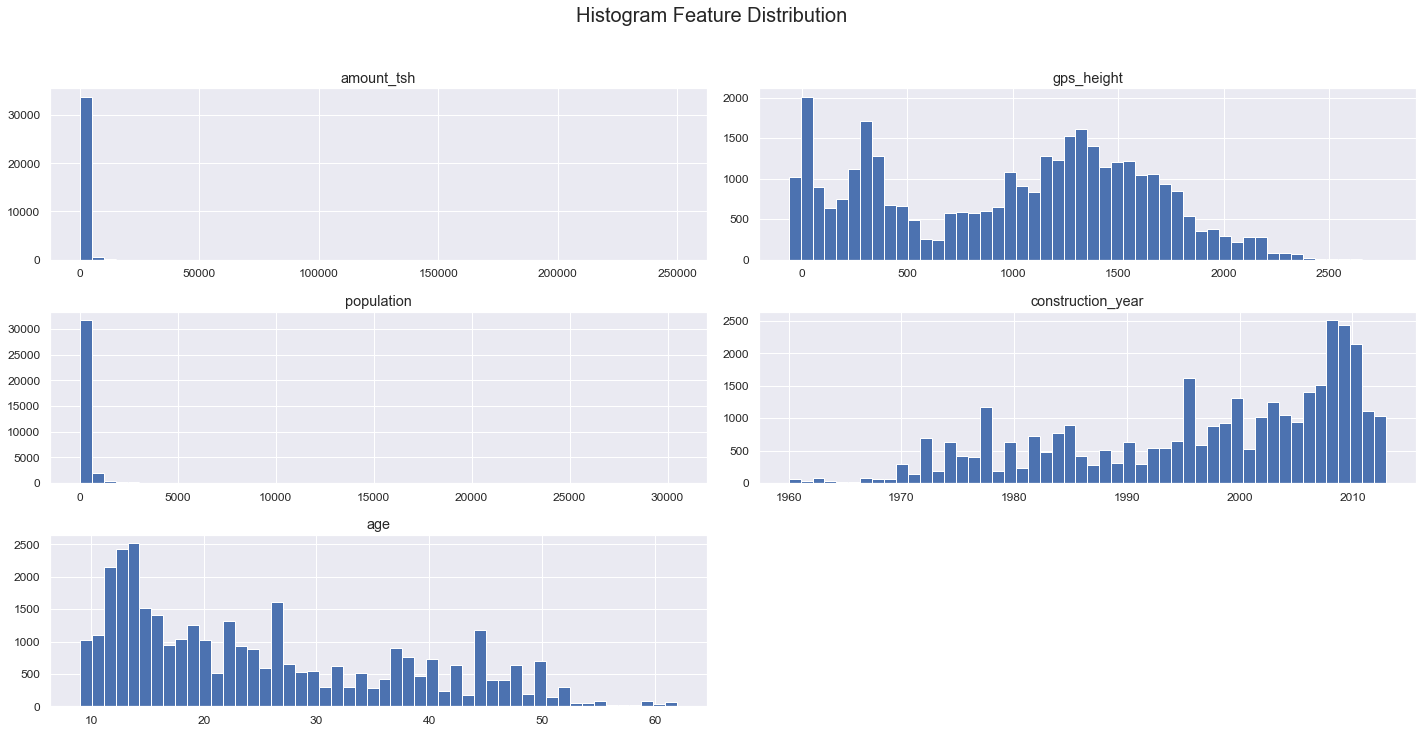

In [24]:
df.hist(bins=50, figsize=(20,10))
plt.suptitle('Histogram Feature Distribution', x=0.5, y=1.02, ha='center', fontsize=20)
plt.tight_layout()
plt.show()

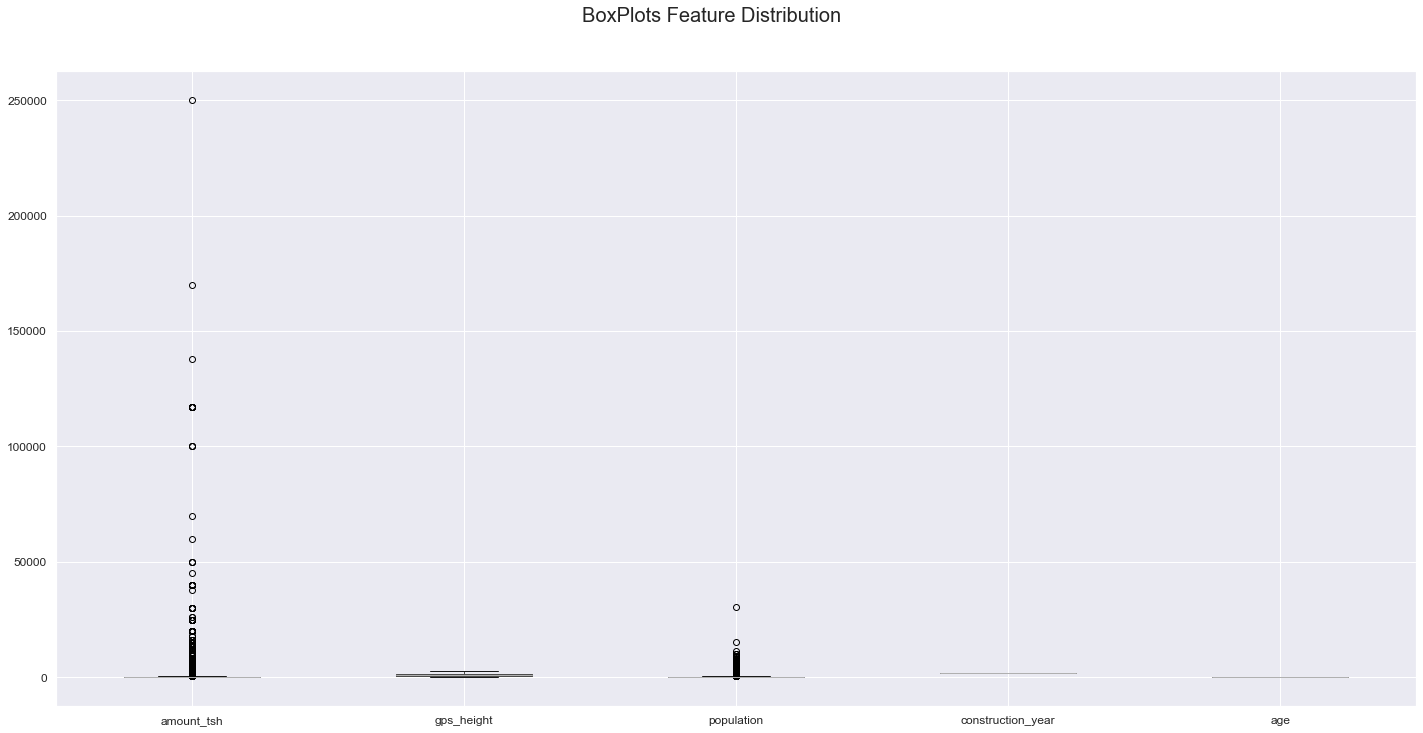

In [25]:
df.boxplot(figsize=(20,10))
plt.suptitle('BoxPlots Feature Distribution', x=0.5, y=1.02, ha='center', fontsize=20)
plt.tight_layout()
plt.show()

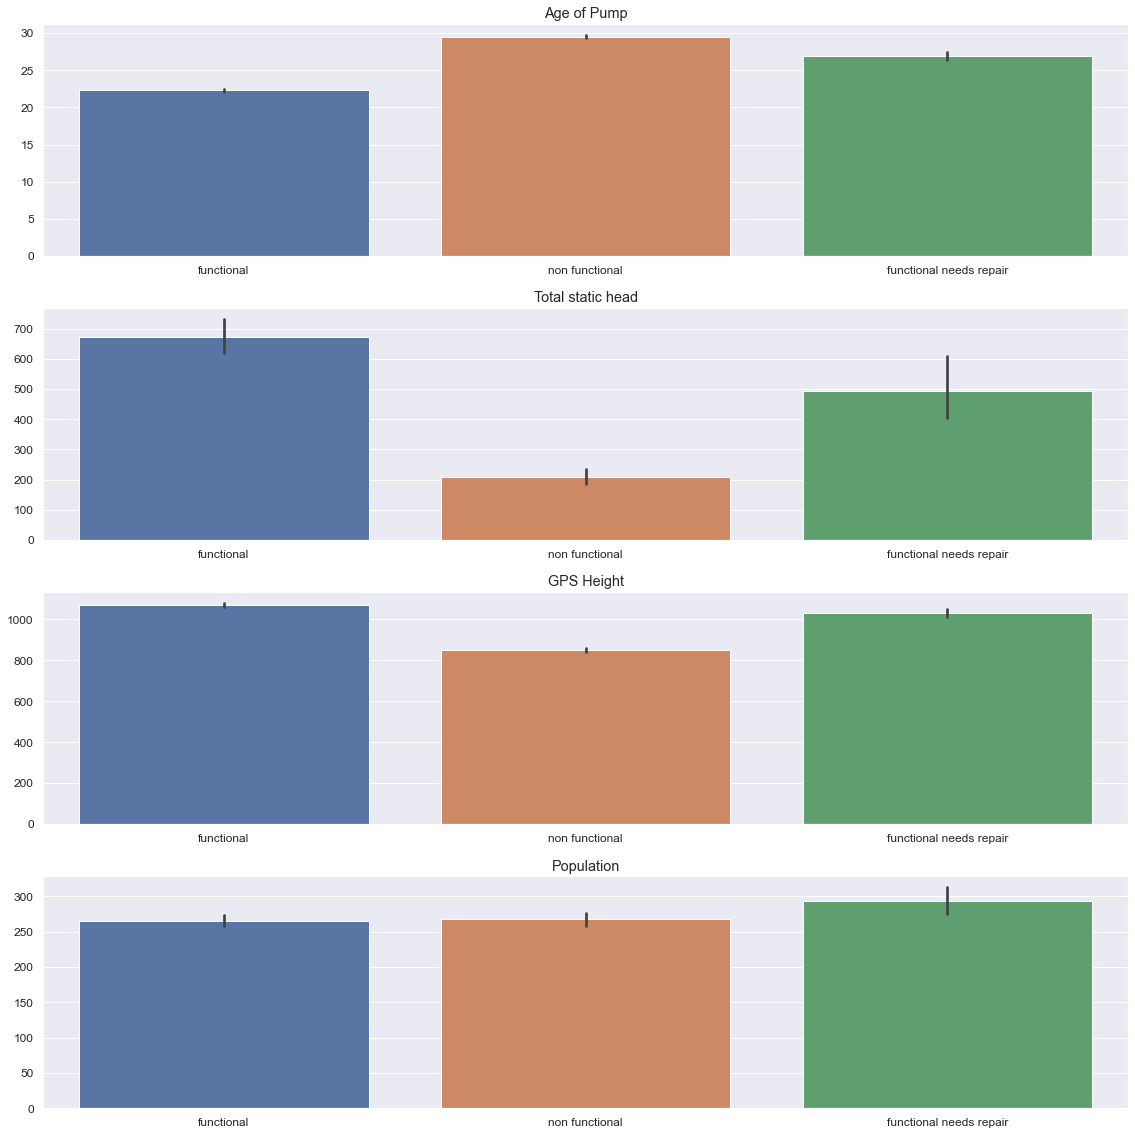

In [26]:
# Plot 4 rows and 1 column (can be expanded)

fig, ax = plt.subplots(4,1, sharex=False, figsize=(16,16))
#fig.suptitle('Main Title')


sns.barplot(x="status_group", y="age", data=df, ax=ax[0])
ax[0].set_title('Age of Pump')
#ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("")
ax[0].set_ylabel("")

sns.barplot(x="status_group", y="amount_tsh", data=df, ax=ax[1])
ax[1].set_title('Total static head')
#ax[1].tick_params('x', labelrotation=45)
ax[1].set_xlabel("")
ax[1].set_ylabel("")

sns.barplot(x="status_group", y="gps_height", data=df, ax=ax[2])
ax[2].set_title('GPS Height')
#ax[2].tick_params('x', labelrotation=45)
ax[2].set_xlabel("")
ax[2].set_ylabel("")

sns.barplot(x="status_group", y="population", data=df, ax=ax[3])
ax[3].set_title('Population')
#ax[3].tick_params('x', labelrotation=45)
ax[3].set_xlabel("")
ax[3].set_ylabel("")
plt.tight_layout()
plt.show()

In [27]:
df.columns

Index(['amount_tsh', 'gps_height', 'region', 'population', 'public_meeting', 'permit', 'construction_year', 'extraction_type', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'status_group', 'age'], dtype='object')

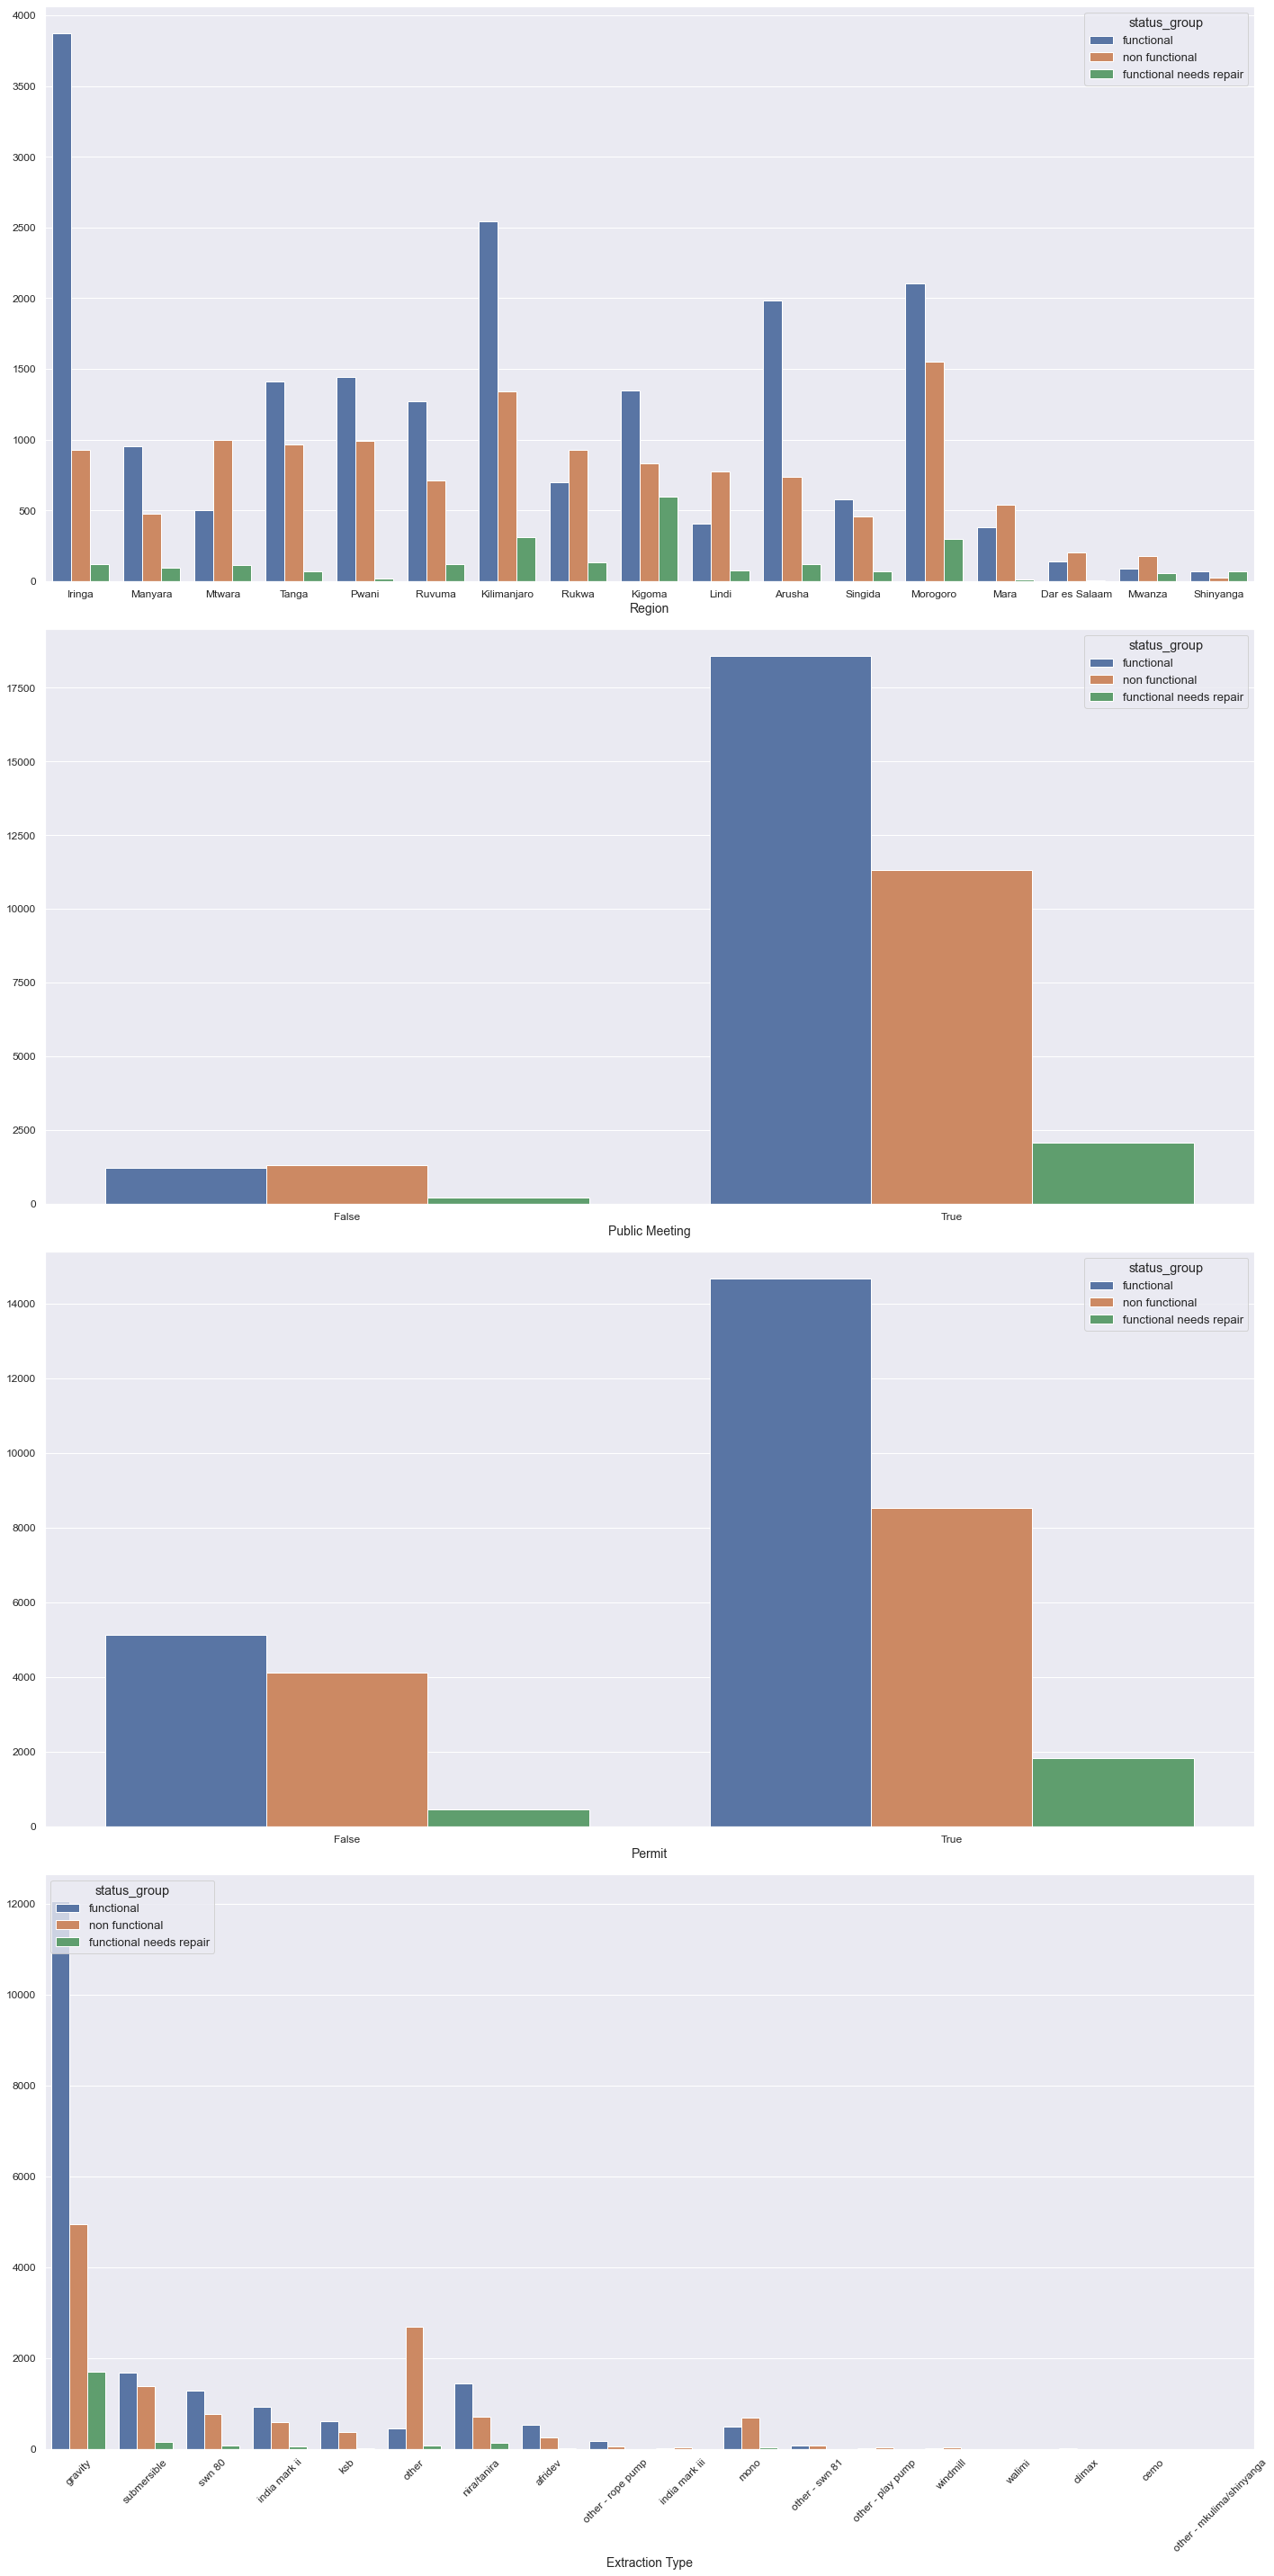

In [28]:
fig = plt.figure(figsize=(20,40))

plt.subplot(4,1,1)
plt.title("", size=20)
sns.countplot(x="region", hue="status_group", data=df)
plt.xlabel("Region")
plt.ylabel("")

plt.subplot(4,1,2)
plt.title("", size=20)
sns.countplot(x="public_meeting", hue="status_group", data=df)
plt.xlabel("Public Meeting")
plt.ylabel("")

plt.subplot(4,1,3)
plt.title("", size=20)
sns.countplot(x="permit", hue="status_group", data=df)
plt.xlabel("Permit")
plt.ylabel("")

plt.subplot(4,1,4)
plt.title("", size=20)
sns.countplot(x="extraction_type", hue="status_group", data=df)
plt.xlabel("Extraction Type")
plt.xticks(rotation=45)
plt.ylabel("")

plt.tight_layout()
plt.show()

In [29]:
df.columns

Index(['amount_tsh', 'gps_height', 'region', 'population', 'public_meeting', 'permit', 'construction_year', 'extraction_type', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'status_group', 'age'], dtype='object')

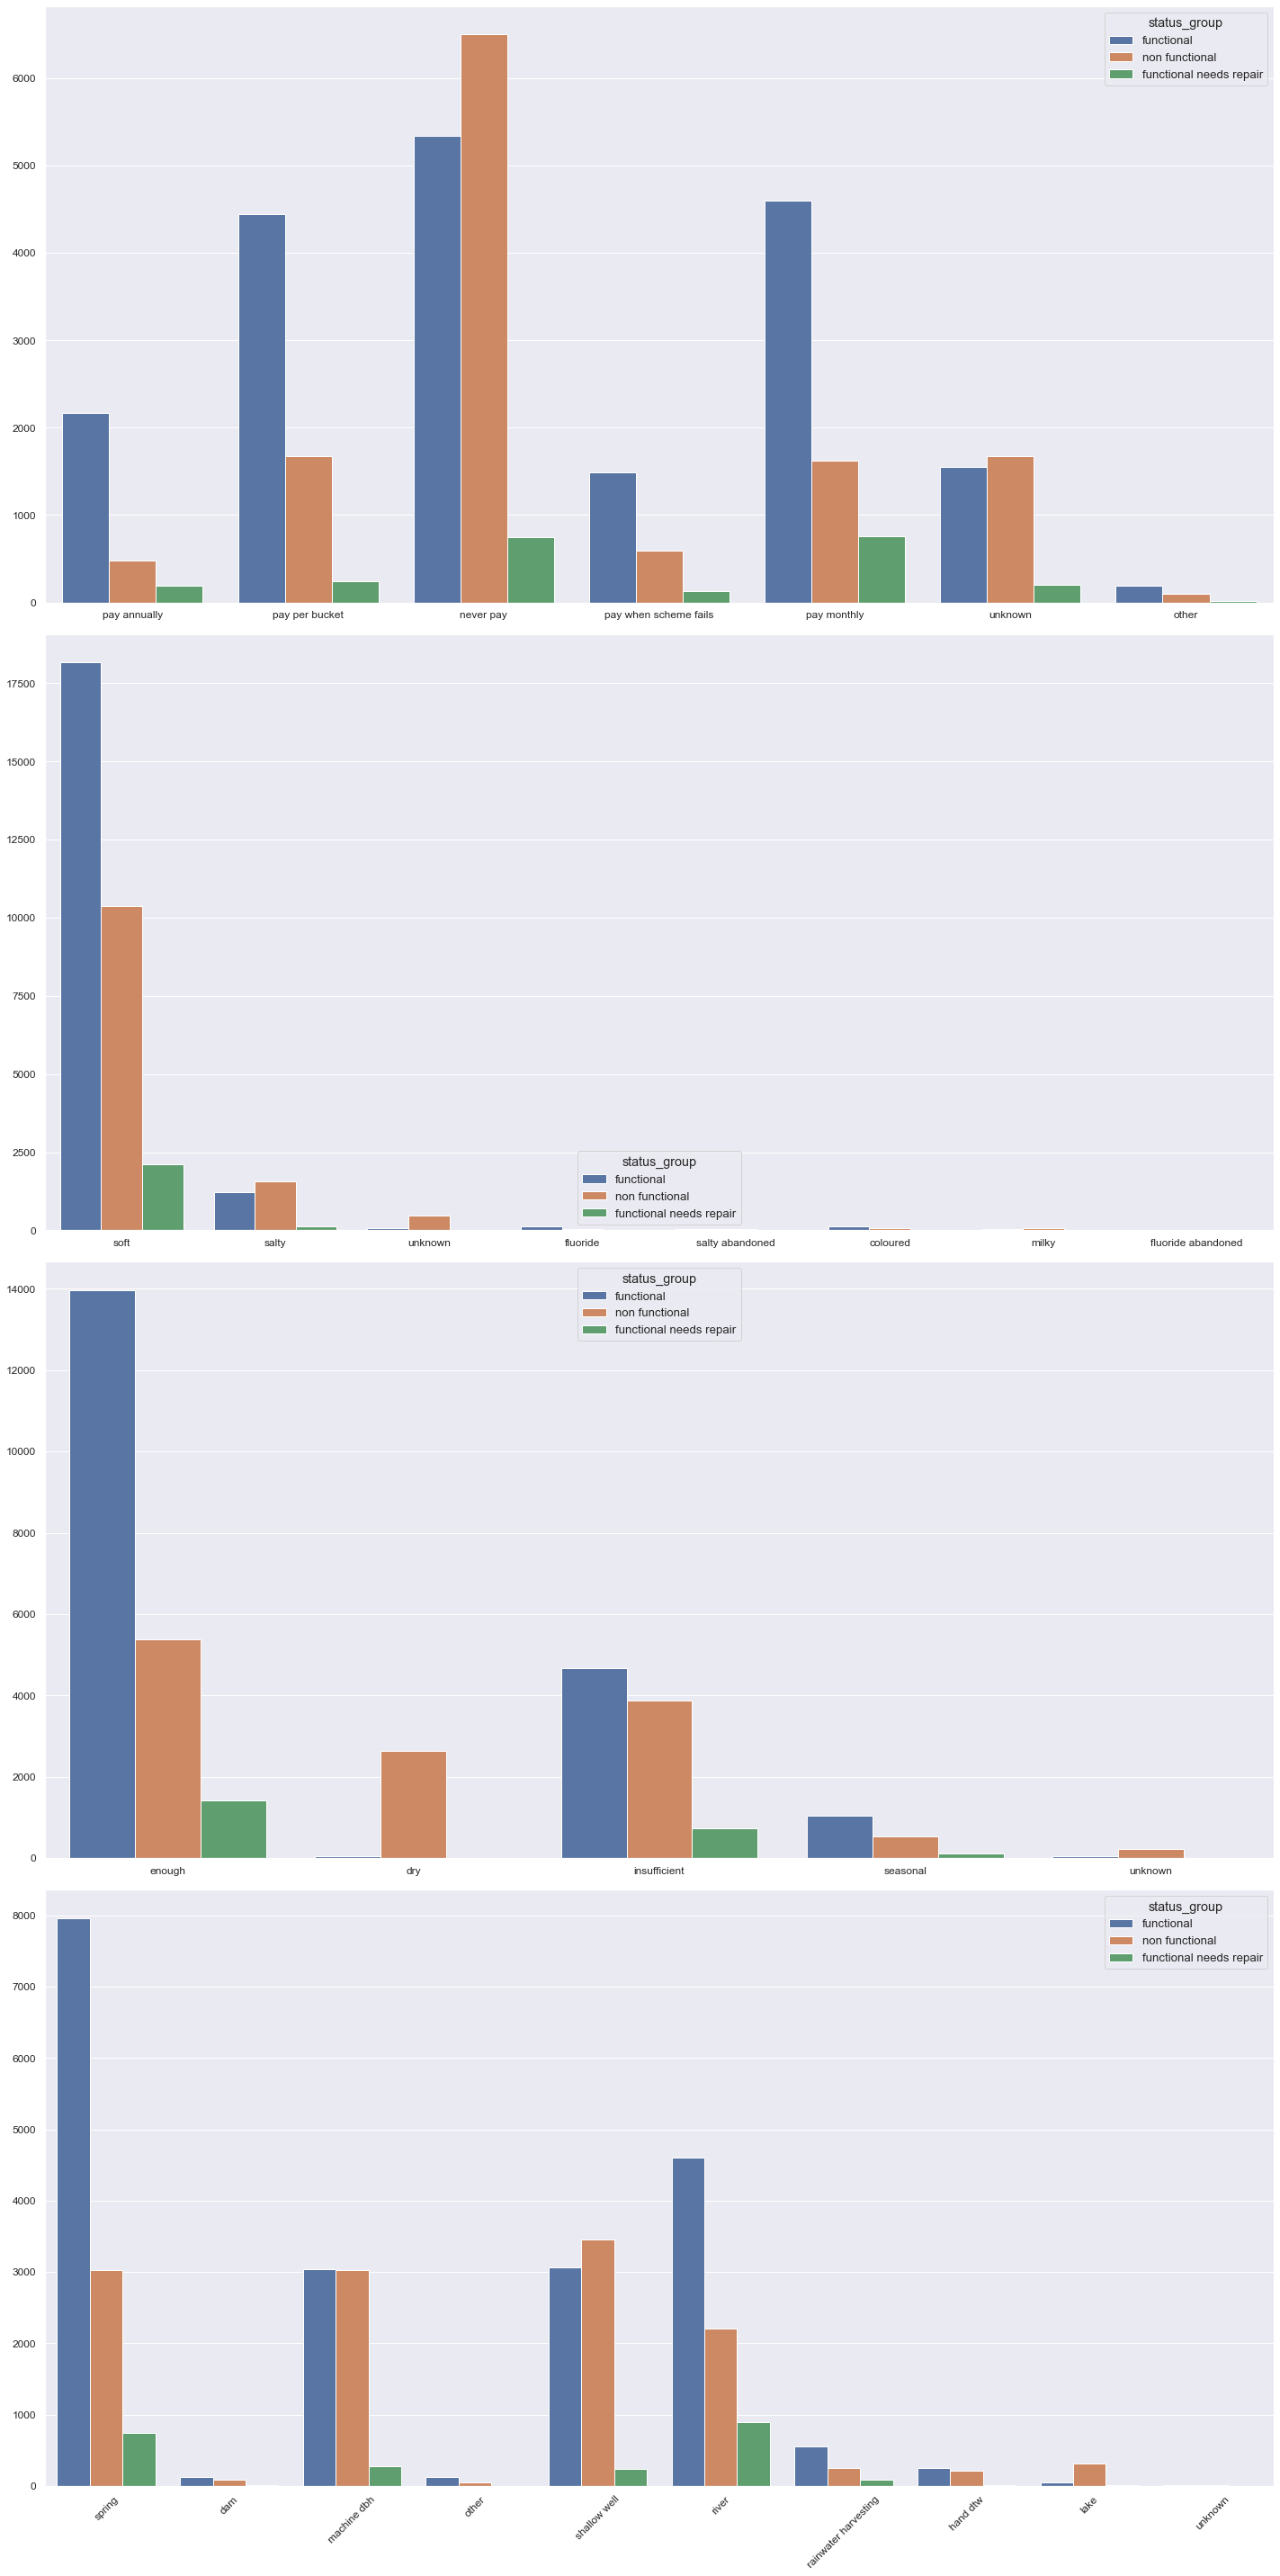

In [30]:
fig = plt.figure(figsize=(20,40))

plt.subplot(4,1,1)
plt.title("", size=20)
sns.countplot(x="payment", hue="status_group", data=df)
plt.xlabel("")
plt.ylabel("")

plt.subplot(4,1,2)
plt.title("", size=20)
sns.countplot(x="water_quality", hue="status_group", data=df)
plt.xlabel("")
plt.ylabel("")

plt.subplot(4,1,3)
plt.title("", size=20)
sns.countplot(x="quantity", hue="status_group", data=df)
plt.xlabel("")
plt.ylabel("")

plt.subplot(4,1,4)
plt.title("", size=20)
sns.countplot(x="source", hue="status_group", data=df)
plt.xlabel("")
plt.xticks(rotation=45)
plt.ylabel("")

plt.tight_layout()
plt.show()

In [31]:
df.waterpoint_type.value_counts()

communal standpipe             19243
hand pump                       7732
communal standpipe multiple     3986
other                           3331
improved spring                  352
cattle trough                     53
dam                                4
Name: waterpoint_type, dtype: int64

### Bivariate Data Exploration

<Figure size 1440x1440 with 0 Axes>

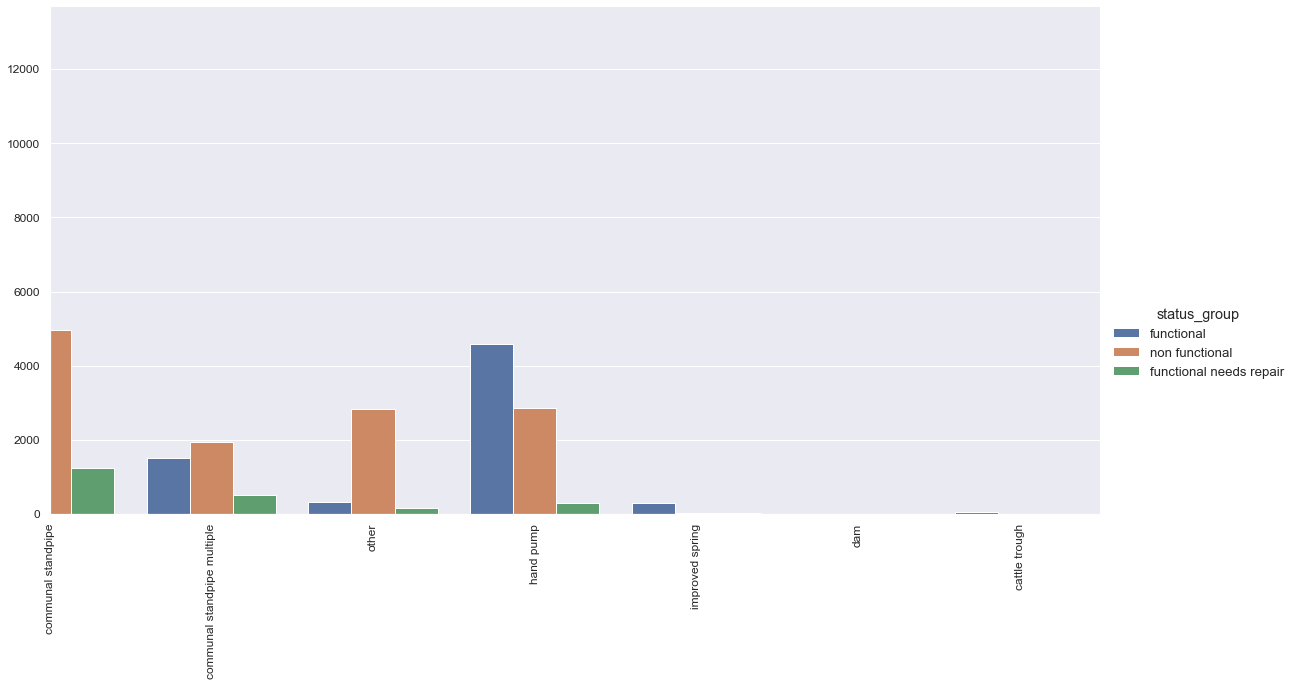

In [32]:
plt.figure(figsize=(20,20))


g = sns.catplot(x='waterpoint_type', hue = 'status_group', 
            kind='count', data=df,
            height = 8, aspect = 2)

g.set_xlabels("")
g.set_ylabels("")
#g = (g.set_axis_labels("Tip","Total bill(USD)").set(xlim=(0,10),ylim=(0,100)


g.set(xlim=(0,None))
g.set_xticklabels(rotation=90)

plt.suptitle('', x=0.5, y=1.02, ha='center', fontsize=20)

plt.show()

### Correlation

In [33]:
df.corr()

,amount_tsh,gps_height,population,construction_year,age
amount_tsh,1.00,0.05,-0.01,0.01,-0.01
gps_height,0.05,1.00,-0.07,0.01,-0.01
population,-0.01,-0.07,1.00,0.02,-0.02
construction_year,0.01,0.01,0.02,1.00,-1.00
age,-0.01,-0.01,-0.02,-1.00,1.00


In [34]:
# plt.figure(figsize=(16,9))
# sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
# plt.title("", fontsize=20)
# plt.show()

## Data Preprocessing

### Treat Data Types

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34701 entries, 0 to 34700
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         34701 non-null  float64
 1   gps_height         34701 non-null  int64  
 2   region             34701 non-null  object 
 3   population         34701 non-null  int64  
 4   public_meeting     34701 non-null  object 
 5   permit             34701 non-null  object 
 6   construction_year  34701 non-null  float64
 7   extraction_type    34701 non-null  object 
 8   payment            34701 non-null  object 
 9   water_quality      34701 non-null  object 
 10  quantity           34701 non-null  object 
 11  source             34701 non-null  object 
 12  waterpoint_type    34701 non-null  object 
 13  status_group       34701 non-null  object 
 14  age                34701 non-null  float64
dtypes: float64(3), int64(2), object(10)
memory usage: 4.0+ MB


### Perform One-Hot Encoding

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34701 entries, 0 to 34700
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         34701 non-null  float64
 1   gps_height         34701 non-null  int64  
 2   region             34701 non-null  object 
 3   population         34701 non-null  int64  
 4   public_meeting     34701 non-null  object 
 5   permit             34701 non-null  object 
 6   construction_year  34701 non-null  float64
 7   extraction_type    34701 non-null  object 
 8   payment            34701 non-null  object 
 9   water_quality      34701 non-null  object 
 10  quantity           34701 non-null  object 
 11  source             34701 non-null  object 
 12  waterpoint_type    34701 non-null  object 
 13  status_group       34701 non-null  object 
 14  age                34701 non-null  float64
dtypes: float64(3), int64(2), object(10)
memory usage: 4.0+ MB


In [37]:
df.describe(include='all').head(2)

,amount_tsh,gps_height,region,population,public_meeting,permit,construction_year,extraction_type,payment,water_quality,quantity,source,waterpoint_type,status_group,age
count,34701.00,34701.00,34701,34701.00,34701,34701,34701.00,34701,34701,34701,34701,34701,34701,34701,34701.00
unique,NaN,NaN,17,NaN,2,2,NaN,18,7,8,5,10,7,3,NaN


In [38]:
df.drop(['region','construction_year','extraction_type','payment','water_quality','quantity','source','waterpoint_type'], axis=1, inplace=True)

In [39]:
df.columns

Index(['amount_tsh', 'gps_height', 'population', 'public_meeting', 'permit', 'status_group', 'age'], dtype='object')

In [40]:
df_category = df[['public_meeting', 'permit']]
df_category

,public_meeting,permit
0,True,False
1,True,True
2,True,True
3,True,True
4,True,False
...,...,...
34696,True,True
34697,True,True
34698,True,True
34699,True,True


In [41]:
df_category1 = pd.get_dummies(df_category, drop_first=True)
df_category1

,public_meeting_True,permit_True
0,1,0
1,1,1
2,1,1
3,1,1
4,1,0
...,...,...
34696,1,1
34697,1,1
34698,1,1
34699,1,1


In [42]:
df2 = pd.concat([df, df_category1], axis=1)

In [43]:
df2

,amount_tsh,gps_height,population,public_meeting,permit,status_group,age,public_meeting_True,permit_True
0,6000.00,1390,109,True,False,functional,23.00,1,0
1,25.00,686,250,True,True,functional,13.00,1,1
2,0.00,263,58,True,True,non functional,36.00,1,1
3,20.00,0,1,True,True,functional,13.00,1,1
4,0.00,62,345,True,False,functional,11.00,1,0
...,...,...,...,...,...,...,...,...,...
34696,0.00,540,210,True,True,non functional,55.00,1,1
34697,500.00,351,89,True,True,non functional,15.00,1,1
34698,10.00,1210,125,True,True,functional,23.00,1,1
34699,4700.00,1212,56,True,True,functional,26.00,1,1


In [44]:
df2.drop(['public_meeting','permit'], axis=1, inplace=True)

In [45]:
df2.head()

,amount_tsh,gps_height,population,status_group,age,public_meeting_True,permit_True
0,6000.00,1390,109,functional,23.00,1,0
1,25.00,686,250,functional,13.00,1,1
2,0.00,263,58,non functional,36.00,1,1
3,20.00,0,1,functional,13.00,1,1
4,0.00,62,345,functional,11.00,1,0


In [48]:
df3 = df2[['amount_tsh', 'gps_height', 'population', 'age', 'public_meeting_True', 'permit_True', 'status_group']]

In [49]:
df3

,amount_tsh,gps_height,population,age,public_meeting_True,permit_True,status_group
0,6000.00,1390,109,23.00,1,0,functional
1,25.00,686,250,13.00,1,1,functional
2,0.00,263,58,36.00,1,1,non functional
3,20.00,0,1,13.00,1,1,functional
4,0.00,62,345,11.00,1,0,functional
...,...,...,...,...,...,...,...
34696,0.00,540,210,55.00,1,1,non functional
34697,500.00,351,89,15.00,1,1,non functional
34698,10.00,1210,125,23.00,1,1,functional
34699,4700.00,1212,56,26.00,1,1,functional


### Create and save processed dataset

In [50]:
#df3.to_csv("train2.csv",index=False)

### Train Test Split

In [ ]:
X = df.iloc[:,:]
y = df.iloc[:,:]

In [ ]:
df.shape

### Treat Imbalance Data

In [ ]:
y.value_counts()

In [ ]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [ ]:
new_X, new_y = ros.fit_resample(X, y)

In [ ]:
new_y[].value_counts()

In [ ]:
new_X

### Train Test Split Cont'd

In [ ]:
X.values, y.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Train Test Split to create Train, Validation and Test Set

In [ ]:
#Set test set size
X_df, X_test, y_df, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0) 

In [ ]:
X_df.shape, X_test.shape, y_df.shape, y_test.shape

In [ ]:
X_train, X_val = train_test_split(X_df, test_size=0.2, random_state=0)

In [ ]:
X_train.shape, X_val.shape

## Feature Selection

### Using SelectKBest

In [ ]:
X_new = SelectKBest(f_regression, k=10).fit_transform(X_train,y_train)

In [ ]:
X_new[0:5]

### Univariate Feature Selection

In [ ]:
select_feature = SelectKBest(chi2, k=10).fit(X_train,y_train)

In [ ]:
select_feature.scores_

### Recursive Feature Elimination

In [ ]:
rfe = RFE(estimator=XGBRegressor(),n_features_to_select=10,verbose=1, step=1)

In [ ]:
rfe.fit(X_train,y_train)

In [ ]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),'Ranking':rfe.ranking_}   

In [ ]:
selected_rfe_features

### Recursive Feature Elimnation with Cross Validation

In [ ]:
rfecv = RFECV(estimator=XGBRegressor(), cv=5,scoring="neg_mean_squared_error",verbose=1, step=1)

In [ ]:
rfecv.fit(X_train,y_train)

In [ ]:
print("Optimal no of features:", rfecv.n_features_)

In [ ]:
print("Best features:", rfecv.support_)

In [ ]:
print("Selector Ranking:", rfecv.ranking_)

## Feature Scaling

In [ ]:
X_train

In [ ]:
encoder = LabelEncoder()

In [ ]:
scaler = StandardScaler()

In [ ]:
minmax = MinMaxScaler()

In [ ]:
ohe = OneHotEncoder()

In [ ]:
X_train_scaled = minmax.fit_transform(X_train)

In [ ]:
X_test_scaled = minmax.transform(X_test)

In [ ]:
X_train_scaled

In [ ]:
X_test_scaled

### Model Training

### Using PyCaret

In [ ]:
exp_reg = setup(data = df, target = '', session_id=0, normalize=True) 

In [ ]:
compare_models(exclude=['catboost','lightgbm','lda','qda','mlp','ada','nb','ridge','rbfsvm','svm'],fold=5) #For Classifier

In [ ]:
compare_models(exclude=['omp','br','ard','par','ransac','tr','huber','kr','svm','knn','dt','rf',
                        'et','ada','gbr','mlp','xgboost','lightgbm','catboost'],fold=5) # For Regressor

In [ ]:
model_selected = create_model('catboost')

In [ ]:
print(model_selected)

In [ ]:
tuned_model = tune_model(catboost, optimize='mse')

In [ ]:
print(tuned_model)

In [ ]:
plot_model(tuned_model)

In [ ]:
plot_model(tuned_model, plot = 'error')

In [ ]:
plot_model(tuned_model, plot='feature')

In [ ]:
interpret_model(tuned_model)

In [ ]:
evaluate_model(tuned_model)

In [ ]:
predict_model(tuned_model)

In [ ]:
final_model = finalize_model(tuned_model)

In [ ]:
unseen_predictions = predict_model(final_model, data=data_unseen)
unseen_predictions.head()

## Using Regression or Classification Models

In [ ]:
reg_model

In [ ]:
classi_model

### K-Fold Cross-Validation (Generalization Performance)

In [ ]:
lasso = Lasso(random_state=0)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
lasso_cv = cross_validate(estimator=lasso, X=X_train_scaled, y=y_train, scoring="neg_root_mean_squared_error",
                            cv=kf, n_jobs=-1,return_train_score=True)

In [ ]:
lasso_cv

In [ ]:
np.mean(lasso_cv["train_score"]), np.std(lasso_cv["train_score"])

In [ ]:
np.mean(lasso_cv["test_score"]), np.std(lasso_cv["test_score"])

## Using TPOT

In [ ]:
# tpot = TPOTClassifier(generations=3,population_size=10,scoring='accuracy', cv=5, verbosity=2, random_state=0, 
#                       early_stop=1)

In [ ]:
# tpot.fit(X_train,y_train)

In [ ]:
# tpot.score(X_test, y_test)

### Using XGBoost (Scikit-Learn)

### Using RandomSearchCV

In [ ]:
model = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [ ]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='softmax:multi')

In [ ]:
parameters = {'max_depth': np.arange(3,10,1),
              'eta': np.arange(0.05,0.3,0.05),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,10,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1),
              'reg_alpha':np.arange(0,1,0.1),
              'reg_lambda':np.arange(0,1,0.1)
             }

In [ ]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='')

In [ ]:
randm.fit(X, y)

In [ ]:
randm.best_estimator_

In [ ]:
randm.best_score_

In [ ]:
randm.best_params_

### Final Model

In [ ]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [ ]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [ ]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=100, objective='softmax:multi')

In [ ]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

In [ ]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='error',early_stopping_rounds=10)

In [ ]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='mlogloss',early_stopping_rounds=10)

In [ ]:
y_pred = xgbmodel.predict(X_test_scaled)

In [ ]:
y_pred

### Model Evaluation

In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm

In [ ]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
fig , ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(xgbmodel,X_test_scaled,y_test,values_format='.4g',ax=ax)
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
plot_roc_curve(xgbmodel,X_test,y_test)
plt.show()

In [ ]:
mse = mean_squared_error(y_test,y_pred)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
r2score = r2_score(y_test,y_pred)
r2score

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted", fontsize=20)
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Plot Feature Importances

In [ ]:
rf.feature_importances_

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)

In [ ]:
feat_importances

In [ ]:
feat_importances.nlargest(10).plot(kind='barh', figsize=(10,10))
plt.title('Feature Importances')
plt.show()

### The permutation based importance

In [ ]:
perm_importance = permutation_importance(rf,X_test,y_test, random_state=0, scoring='neg_mean_squared_error')

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10,10))
plt.title("Permutation-based Importance")
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

### Compute Importance from SHAP Values

In [ ]:
explainer = shap.TreeExplainer(rf)

In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_test)

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [ ]:
X.columns

In [ ]:
xgbmodel.get_booster().feature_names = [X.columns]

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

In [ ]:
xgb.to_graphviz(xgbmodel,num_trees=100)

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Plot Tree

In [ ]:
X.columns

In [ ]:
plt.figure(figsize=(40,25))
plot_tree(treeclf, feature_names=X.columns,class_names=['0','1'], fontsize=14, filled=True)
plt.show()

### Cross-Validation

In [ ]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='')

In [ ]:
cv.mean()

### Using XGBoost (API)

In [ ]:
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)

In [ ]:
params = {'n_estimators':,
          'learning_rate':,
          'max_depth':,
          'objective': '',
          'num_class': ,
          'seed': 0,
          'eval_metric':''}

In [ ]:
xgbmodel = xgb.train(params=params,dtrain=dtrain,num_boost_round=100,evals=[(dtest,"Test")],
                     early_stopping_rounds=10)

In [ ]:
y_pred = xgbmodel.predict(dtest)

In [ ]:
y_pred

### Cross-Validation (API)

In [ ]:
cv = xgb.cv(params=params,
            dtrain=dtrain,
            num_boost_round=100,
            nfold=5,
            stratified=False,
            folds=None,
            metrics=('merror'),
            obj=None,
            feval=None,
            maximize=False,
            early_stopping_rounds=10,
            fpreproc=None,
            as_pandas=True,
            verbose_eval=None,
            show_stdv=True,
            seed=0,
            callbacks=None,
            shuffle=True,)

In [ ]:
cv

In [ ]:
cv['test-merror-mean'].min()

### Model Evaluation (Classification)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm

In [ ]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
fig , ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(xgbmodel,X_test_scaled,y_test,values_format='.4g',ax=ax)
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
plot_roc_curve(xgbmodel,X_test,y_test)
plt.show()

### Model Evaluation (Regression)

In [ ]:
mse = mean_squared_error(y_test,y_pred)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
r2score = r2_score(y_test,y_pred)
r2score

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Table Formatted View

In [ ]:
table = X_test.copy()

In [ ]:
table["True Value"] = y_test.copy()

In [ ]:
table["Predicted"] = np.round(lr_pred,2)

In [ ]:
table

### Cross-Validation

In [ ]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='accuracy')

In [ ]:
cv.mean()

### Feature Selection

In [ ]:
df.columns

In [ ]:
df2 = df[['']]

In [ ]:
df2

In [ ]:
X = df2.iloc[:,0:7]
y = df2.iloc[:,7]

In [ ]:
X.values, y.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
xgbmodel2 = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [ ]:
xgbmodel2 = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [ ]:
xgbmodel2.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

In [ ]:
xgbmodel2.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=10)

In [ ]:
y_pred = xgbmodel2.predict(X_test)

In [ ]:
y_pred

In [ ]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgbmodel2,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
plot_roc_curve(xgbmodel2,X_test,y_test)
plt.show()

### Model Prediction

In [ ]:
testdata = pd.read_csv()

In [ ]:
answer = xgbmodel.predict(testdata)

In [ ]:
answer

### Model Tuning

### Using RandomSearchCV

In [ ]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [ ]:
model = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [ ]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [ ]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='')

In [ ]:
randm.fit(X, y)

In [ ]:
randm.best_estimator_

In [ ]:
randm.best_score_

In [ ]:
randm.best_params_

### Using GridSearchCV

In [ ]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [ ]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [ ]:
grids = GridSearchCV(estimator=model,param_grid=parameters,scoring='accuracy',
                     n_jobs=-1,cv=5,verbose=1,return_train_score=True)

In [ ]:
grids.fit(X,y)

In [ ]:
grids.best_estimator_

### Final Model

In [ ]:
xgbnew = XGBClassifier(random_state=0, n_estimators=, objective='binary:logistic',max_depth=,
                      gamma=, min_child_weight=,learning_rate=,subsample=,colsample_bytree=)

In [ ]:
xgbnew = XGBRegressor(random_state=0, n_estimators=, objective='binary:logistic',max_depth=,
                      gamma=, min_child_weight=,learning_rate=,subsample=,colsample_bytree=)

In [ ]:
xgbnew.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

In [ ]:
y_pred = xgbnew.predict(X_test)

In [ ]:
y_pred

In [ ]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgbnew,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
plot_roc_curve(xgbnew,X_test,y_test)
plt.show()

### Save the Model

In [ ]:
filename = 'model.sav'
dump(xgbnew,open(filename,'wb'))

### Load the Model

In [ ]:
loaded_model = load(open(filename,'rb'))

In [ ]:
loaded_model

#### Python code done by Dennis Lam